In [1]:
import numpy as np
from scipy.io import loadmat
from cartopy import config
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
import numpy as np
def co3eq(temp, s, z, alk, dic):
    """
    Calculates pCO2, pH, H2CO3*, HCO3, and CO3 concentrations.

    NOTE: Currently you have to do this for a single point at a time. Due to
    dependence on `np.roots`, it isn't extremely easy to vectorize, although
    I imagine it is possible if one spent a little time on it.

    Contact: Riley.Brady@colorado.edu


    Parameters
    ----------
    temp : float
        Temperature at location (degC)
    s : float
        Salinity at location (ppt)
    z : float
        Depth at location (m)
    alk : float
        Alkalinity at location (umol/kg)
    dic : float
        DIC at location (umol/kg)


    Returns
    -------
    pCO2 (uatm), pH, CO2 (umol/kg), HCO3 (umol/kg), CO3 (umol/kg) as floats.


    Reference
    ---------
    Emerson and Hedges 2008: Chemical Oceanography and the Marine Carbon Cycle.
    (4A 1.2)


    Example
    -------
    pco2, pH, CO2, HCO3, CO3 = co3eq(15, 35, 10, 2300, 2100)
    """
    # Conversions
    t = temp + 273.15
    Pr = z/10
    alk = alk * 1e-6
    dic = dic * 1e-6
    R = 83.131

    # Calculate total borate from chlorinity
    tbor = .000416 * s / 35

    # Calculate Henry's Law coefficient, K0 (Weiss, 1974)
    U1 = -60.2409 + 93.4517 * (100/t) + 23.3585*np.log(t/100)
    U2 = s * (.023517 - .023656 * (t/100) + .0047036 * (t/100)**2)
    KH = np.exp(U1 + U2)

    # Calculate KB from temp and salinity (Dickson, 1990)
    KB = np.exp((-8966.9 - 2890.53 * s**0.5 - 77.942 * s + 1.728 * s**1.5
                 - 0.0996 * s**2)/t + 148.0248 + 137.1942 * s**0.5 + 1.62142 * s
                 - (24.4344 + 25.085 * s**0.5 + 0.2474 * s) * np.log(t)
                 + 0.053105 * s**0.5 * t);

    # Calculate K1 and K2 (Luecker et al., 2000)
    K1 = 10**(-(3633.86/t - 61.2172 + 9.67770 * np.log(t) - 0.011555 * s
                + 0.0001152 * s**2))
    K2 = 10**(-(471.78/t + 25.92990 - 3.16967 * np.log(t) - 0.01781 * s
                + 0.0001122 * s**2))

    # Pressure variation of K1, K2, and KB (Millero, 1995)
    dvB = -29.48 + 0.1622 * temp - .002608 * (temp)**2
    dv1 = -25.50 + 0.1271 * temp
    dv2 = -15.82 - 0.0219 * temp
    dkB = -.00284
    dk1 = -.00308 + 0.0000877 * temp
    dk2 = .00113 - .0001475 * temp
    KB  = (np.exp(-(dvB / (R * t)) * Pr + (0.5 * dkB / (R * t)) * Pr**2)) * KB
    K1  = (np.exp(-(dv1 / (R * t)) * Pr + (0.5 * dk1 / (R * t)) * Pr**2)) * K1
    K2  = (np.exp(-(dv2 / (R * t)) * Pr + (0.5 * dk2 / (R * t)) * Pr**2)) * K2

    # Temperature dependence of KW (DOE, 1994)
    KW1 = 148.96502 - 13847.26 / t - 23.65218 * np.log(t)
    KW2 = (118.67 / t - 5.977 + 1.0495 * np.log(t)) * s**.5 - 0.01615 * s
    KW  = np.exp(KW1 + KW2)

    # solve for H ion (Zeebe and Wolf-Gladrow, 2000)
    a1 = 1
    a2 = (alk + KB + K1)
    a3 = (alk * KB - KB * tbor - KW + alk * K1 + K1 * KB + K1 * K2 - dic * K1)
    a4 = (-KW  * KB + alk * KB * K1 - KB * tbor * K1 - KW * K1 + alk * K1 * K2
          + KB * K1 * K2 - dic * KB * K1 - 2 * dic * K1 * K2)
    a5 = (-KW * KB * K1 + alk * KB * K1 * K2 - KW * K1 * K2 - KB * tbor * K1
          * K2 - 2 * dic * KB * K1 * K2)
    a6 = -KB * KW * K1 * K2
    p = [a1, a2, a3, a4, a5, a6]
    r = np.roots(p)
    h = np.max(np.real(r))

    # Calculate bicarbonate, carbonate, and aqueous CO2 usin DIC, Alk, and H+
    hco3 = dic / (1 + h/K1 + K2/h) * 1e6
    co3 = dic / (1 + h/K2 + h * h / (K1 * K2)) * 1e6
    co2 = dic / (1 + K1/h + K1 * K2 / (h * h)) * 1e6
    pco2 = co2 / KH
    pH = -np.log10(h)

    # Calculate B(OH)4 and OH
    BOH4 = KB * tbor / (h + KB)
    OH = KW / h

    # recalculate DIC and Alk to check calculations
    Ct = (hco3 + co3 + co2) * 1e6
    At = (hco3 + 2*co3 + BOH4 + OH - h) * 1e6

    return pco2, pH, co2, hco3, co3


# 1

In [4]:
pH_current = 8.1
pH_new = 7.8 #expected pH at end of century

H_current = 10**(-1*pH_current)
H_new = 10**(-1*pH_new)
percent_change = (H_new - H_current)/H_current*100

#print(H_current, H_new)
print(f'The expected percent change in H+ concentration from the current condition until the end of the century is {percent_change:0.3f}%')

The expected percent change in H+ concentration from the current condition until the end of the century is 99.526%


In [5]:
pCO2_current = 400*10**-6 #atm
pCO2_new = 600*10**-6 #atm
CO3_current = pCO2_current/H_current**2
CO3_new = pCO2_new/H_new**2

percent_change2 = (CO3_new - CO3_current)/CO3_current*100
print(f'The expected percent change in carbonate concentration from the current condition until the end of the century is {percent_change2:0.3f}%')

The expected percent change in carbonate concentration from the current condition until the end of the century is -62.322%


# 2
Historical ocean pH can be estimated by using chemical proxies that provide indirect measurements of seawater chemistry.  We can analyze the chemical composition of fossil shells found in the ocean floor to understand past ocean carbonate chemistry.  We can also use ice cores to determine historical atmospheric carbon dioxide concentrations. If we assume that the ocean surface water and the atmosphere have always been in approximate equilibrium, we can use these ice cores to estimate $pCO_2$ in the ocean and infer ocean pH.  Using these proxys assumes that historical atmospheric and oceanic chemical processes are the same as those today.


# 3 
The saturation state, $\Omega$, can be defined as $\frac{[Ca_2^+][CO_3^{2−}]}{K_{sp}}$.  Because $[Ca_2^+]$ is closely proportional to salinity, $\Omega$ is largely determined by variations in $[CO_3^{2−}]$ (Doney et al. 2009), which can be calculated from DIC and total alkalinity data ($[CO_3^{2−}] = Alk - DIC$). If we assume that alkilinity remains roughly constant with depth in the ocean, we see that an increase in DIC (e.g. from increased fossil fuel burning) will lead to a corresponding decrease in carbonate ion concentration which will then decrease the saturation state. Anthropogenic carbon penetration into the ocean is concentrated in theupper thermocline (where the ocean is typically supersaturated with respect to $[CO_3^{2−}]$) meaning that the saturation state in the upper thermocline will decrease (or become closer to saturation). Eventually the saturation state will decline such that the upper thermocline will become undersaturated with respect to $[CO_3^{2−}]$, leading to a shoaling of the saturation horizon. 

# 4 high-latitude regions

High latitude oceans can take up more $CO_2$ because of their colder temperatures which leads to increased $CO_2$ solubility (solubility pump). This also leads to naturally low carbonate ion concentrations. Decreased sea ice extent in the Arctic means that there is more exposed ocean and this a larger area for air-sea gas exhange. The Arctic ocean recieves extra DIC input from river runoff which is less prevalent at lower latitudes.  Similarly, the Southern surface ocean experiences increased DIC from upwelling in the Deacon cell which brings DIC up from the deeper ocean. From the equation: $CO_3^{2-} = Alk - DIC$, we can see that an increase in DIC will decrease $CO_3^{2-}$, leading to a decreased saturation state and a shoaling of the saturation horizon.

# 5 Experiments

Test exposure to high levels of pCO2


# 6

If the $CO_3^{2-}$ saturation horizon shoals due to ocean acidification, then it will become extremely difficuly for organisms to calcify which means they will remain unprotected and won't be able to survive for as long.  This will decrease the strength of the soft tissue pump because photosynthesis in the upper ocean will decrease.  Additionally, without shells, organic matter will sink much more slowly and will be unable to make it out of the euphotic zone, leading to decreased remineralization in the ocean interior.

Lower concentrations of $CO_3^{2-}$ will also decrease the strength of the hard tissue pump.  A lower saturation state of $CO_3^{2-}$ will decrease $CaCO_3$ precipitation at the surface.  Finally, because there is less $CO_3^{2-}$ organisms will require more energy to produce shells meaning they cannot allocate as much energy to photosynthesis and reproduction.  This will lead to decreased photosynthesis

# 7

In [3]:
alk = loadmat('Alk.mat')['Alk'] #micro-mol/kg
DIC = loadmat('DIC.mat')['DIC'] #micro-mol/kg
lat = loadmat('data_latitude.mat')['data_latitude']
lon = loadmat('data_longitude.mat')['data_longitude']
temp = loadmat('temp.mat')['temp'] # deg C
salt = loadmat('salt.mat')['salt'] #salinity

In [10]:
pCO2 = np.zeros(alk.shape)
pH = np.zeros(alk.shape)
CO2 = np.zeros(alk.shape)
HCO3 = np.zeros(alk.shape)
CO3 = np.zeros(alk.shape)

x = alk.shape[0]
y = alk.shape[1]

for i in range(x):
    for j in range(y):
        if not np.isnan(temp[i,j]) and not np.isnan(alk[i,j]) and not np.isnan(DIC[i,j]) and not np.isnan(salt[i,j]):
            pCO2_temp, pH_temp, CO2_temp, HCO3_temp, CO3_temp = co3eq(temp[i,j], salt[i,j], 0, alk[i,j], DIC[i,j])
            pCO2[i,j] = pCO2_temp
            pH[i,j] = pH_temp
            CO2[i,j] = CO2_temp
            HCO3[i,j] = HCO3_temp
            CO3[i,j] = CO3_temp
        else:
            pCO2[i,j] = np.nan
            pH[i,j] = np.nan
            CO2[i,j] = np.nan
            HCO3[i,j] = np.nan
            CO3[i,j] = np.nan

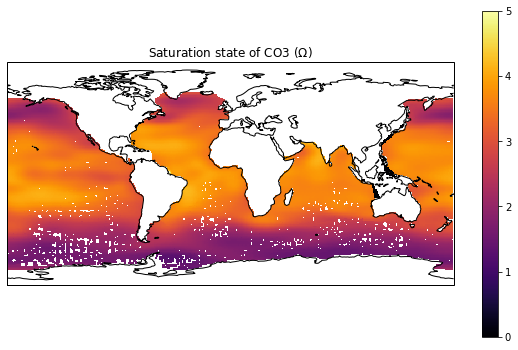

In [12]:
CO3_sat = 65
sat_state = CO3/CO3_sat

plt.figure(figsize=(10,6))

ax = plt.axes(projection=ccrs.PlateCarree())
plt.title('Saturation state of CO3 ($\Omega$)')
ax.coastlines()

plt.pcolormesh(lon, lat, sat_state ,cmap = 'inferno',vmin= 0, vmax = 5,transform=ccrs.PlateCarree())
plt.xlabel('longitude')
plt.ylabel('latitude')
m = plt.cm.ScalarMappable(cmap='inferno')
m.set_array(sat_state)
m.set_clim(0, 5)
plt.colorbar(m)
plt.show()

In the plot above, any place with a saturation state ($/Omega$) above 1 is supersaturated with respect to $CO_3^{2-}$ and any place with a saturation state below 1 is undersaturated. From the plot above, we can see that the surface ocean is supersaturated at all locations.  The lowest saturation states are in the high latitude oceans which makes sense given my answer for question 4.  The equatorial Pacific also has a relatively lower saturation state.  This is most likely due to upwelling in this region which brings DIC to the surface from the deep ocean, in turn decreasing the concentration of $CO_3^{2-}$.

In [7]:
DICb = DIC+200
pCO2b = np.zeros(alk.shape)
pHb = np.zeros(alk.shape)
CO2b = np.zeros(alk.shape)
HCO3b = np.zeros(alk.shape)
CO3b = np.zeros(alk.shape)

x = alk.shape[0]
y = alk.shape[1]

for i in range(x):
    for j in range(y):
        if not np.isnan(temp[i,j]) and not np.isnan(alk[i,j]) and not np.isnan(DICb[i,j]) and not np.isnan(salt[i,j]):
            pCO2_temp, pH_temp, CO2_temp, HCO3_temp, CO3_temp = co3eq(temp[i,j], salt[i,j], 0, alk[i,j], DICb[i,j])
            pCO2b[i,j] = pCO2_temp
            pHb[i,j] = pH_temp
            CO2b[i,j] = CO2_temp
            HCO3b[i,j] = HCO3_temp
            CO3b[i,j] = CO3_temp
        else:
            pCO2b[i,j] = np.nan
            pHb[i,j] = np.nan
            CO2b[i,j] = np.nan
            HCO3b[i,j] = np.nan
            CO3b[i,j] = np.nan

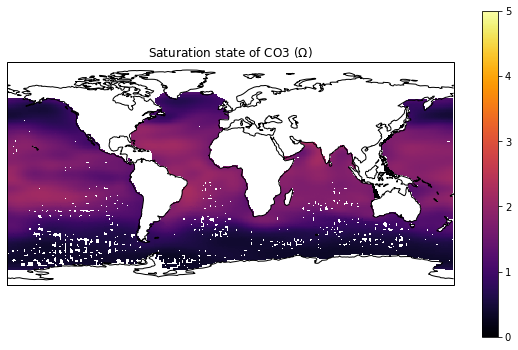

In [8]:
CO3_sat = 65
sat_stateb = CO3b/CO3_sat

plt.figure(figsize=(10,6))

ax = plt.axes(projection=ccrs.PlateCarree())
plt.title('Saturation state of CO3 ($\Omega$)')
ax.coastlines()

plt.pcolormesh(lon, lat, sat_stateb ,cmap = 'inferno',vmin=0, vmax = 5,transform=ccrs.PlateCarree())
plt.xlabel('longitude')
plt.ylabel('latitude')
m = plt.cm.ScalarMappable(cmap='inferno')
m.set_array(sat_stateb)
m.set_clim(0, 5)
plt.colorbar(m)
plt.show()

In the plot above we see that the addition of DIC in the ocean leads to a decrease in saturation state at every location.  There are many locations (especially in the high latitude oceans) which are now undersaturated with respect to $CO_3^{2-}$.  Most of the equatorial and mid-latitude oceans are still supersaturated at the surface, but the saturation state has decreased by about 2.  This indicates that the saturation horizon has gotten shallower.